# Newtonian equations

We first recall the Newtonian equations of motion for 2 non-spinning point-particles of masses $m_1$ and $m_2$ with relative position $\vec{r}=\vec{r}_1-\vec{r}_2$ and relative velocity $\vec{v}=\vec{v}_1-\vec{v}_2$.
Coordinates are chosen such that binary is in the orbital plane. The 2 time-dependent unit vectors $\vec{n}$ and $\vec{\lambda}$ are defined by

$$
\vec{r} = r \vec{n} \quad~~~~~~~~~~~~~ \vec{n} = (\cos{\psi}, \sin{\psi}, 0)
$$

$$
\vec{v} = \dot{r} \vec{n} + r \dot{\psi} \vec{\lambda} \quad~~~~~~~~~~~~~ \vec{\lambda} = (-\sin{\psi}, \cos{\psi}, 0)
$$

where $\psi \equiv \psi(t)$. The observer/detector is at position $\vec{R} = R \vec{N}$ where in spherical coordinates, the unit vector

$$
\vec{N} = (\sin{\varphi} \cos{\theta}, \sin{\varphi} \sin{\theta})
$$

Newton's equations in the centre of mass frame are:

$$
r(\psi) = \frac{p}{1 + e \cos{\psi}}
$$

$$
\dot{\psi} = \sqrt{\frac{G m}{p^3}} (1 + e \cos{\psi})^2
$$

where $m = m_1 + m_2$ is the total mass and $p = a(1 - e^2)$ is the semi-latus rectum. It follows from the above that:

$$
\vec{v} = \sqrt{\frac{G m}{p}} (-\sin{\psi}, e + \cos{\psi}, 0)
$$

and

$$
\frac{|\vec{v}|^2}{c^2} = \frac{G m}{c^2 p} (1 + e^2 + 2 e \cos{\psi})
$$

The Newtonian approximation requires $|\vec{v}|^2 \ll c^2$ and thus the dimensionless ratio $G m / c^2 p \ll 1$. The conserved angular momentum of the orbits $\vec{L} = L \vec{e}_z$ is given by:

$$
L = \nu \sqrt{G m p}
$$

where $\nu = \frac{m_1 m_2}{m^2}$ and the total conserved orbital energy is

$$
E = \nu \frac{G m^2}{2 p} (e^2 - 1)
$$

For elliptical orbits: $0 \leq e < 1$ with $-\pi \leq \psi < \pi$ and $r_{\min} = p/(1 + e)$ and $r_{\max} = p/(1 - e)$. The orbital angular frequency $\omega_0$ and period $T$ are given by Kepler laws, namely:

$$
\omega_0 = \sqrt{\frac{G m (1 - e^2)^3}{p^3}} \quad~~~~~~~~~~~~~~ T = \frac{2 \pi}{\omega_0}
$$

Of course, GR effects modify these Newtonian equations of motion, but consistently with the approximation scheme discussed in Section 1.3 they are not included here. Thus for example we ignore precession, namely that over an orbital period the perihelion of elliptical orbits advances by $\Delta_e = 2 \pi \left( \frac{3 G m}{c^2 p} \right)$.

---

# Waveform, energy and angular momentum fluxes

In the quadrupole approximation, the transverse-traceless (TT) component of the waveform is given by

$$
h_{ab}^{TT}(t, \vec{x}) = \frac{2 G}{c^4 R} \ddot{Q}_{ab}^{TT}(t_R)
$$

or equivalently rewriting the traceless quadrupole tensor $Q_{ij} = I_{ij} - \frac{1}{3} I \delta_{ij}$ in terms of the quadrupole moment $I_{ij}$,

$$
h_{cd}^{TT}(t, \vec{x}) = \frac{2 G}{c^4 R} P^{T T a b}_{c d}(\vec{N}) \ddot{I}_{a b}(t_R)
$$

where $t_R = t - R/c$ is the retarded time.
The definition of the quadrupole tensor gives

$$
I_{ab} = \nu m r_a r_b
$$

Then using Newtonian’s equations of motion $\frac{d \vec{v}}{dt} = - \frac{G m \vec{n}}{r^2}$ it follows that:

$$
\ddot{I}_{ab} = 2 \nu m (v_a v_b - \frac{G m}{r} n_a n_b)
$$

Thus, the non-zero components of $\ddot{I}_{ab}$ are

$$
\ddot{I}_{11} = -2 \nu m c^2 \frac{G m}{p c^2} \left( \cos{2\psi} + e \cos^3{\psi} \right)
$$

$$
\ddot{I}_{12} = -2 \nu m c^2 \frac{G m}{p c^2} \left( \sin{2\psi} + e \sin{\psi} (1 + \cos^2{\psi}) \right)
$$

$$
\ddot{I}_{22} = 2 \nu m c^2 \frac{G m}{p c^2} \left( \cos{2\psi} + e \cos{\psi} (1 + \cos^2{\psi}) + e^2 \right)
$$

with $\ddot{I}_{ab}$ having the dimensions of energy. The third derivatives of the quadrupole tensor read

$$
\dddot{I}_{11} = 2 \nu (m c^2) \frac{c}{p} \left( \frac{G m}{p c^2} \right)^{3/2} (1 + e \cos{\psi})^2 \left[ 2 \cos{2 \psi} + 3 e \cos^2{\psi} \sin{\psi} \right]
$$

$$
\dddot{I}_{12} = 2 \nu (m c^2) \frac{c}{p} \left( \frac{G m}{p c^2} \right)^{3/2} (1 + e \cos{\psi})^2 \left[ -2 \cos{2 \psi} + e \cos{\psi} (1 - 3 \cos^2{\psi}) \right]
$$

$$
\dddot{I}_{22} = -2 \nu (m c^2) \frac{c}{p} \left( \frac{G m}{p c^2} \right)^{3/2} (1 + e \cos{\psi})^2 \left[ -2 \sin{2 \psi} + e \sin{\psi} (1 + 3 \cos^2{\psi}) \right]
$$

The gravitational wave (GW) perturbation is given by substituting these expressions into $h_{cd}^{TT}(t, \vec{x})$. In the direction $\vec{N} = \hat{z}$, the plus and cross polarisations are given by:

$$
h_+(t) = \frac{G}{c^4 R} \left( \ddot{I}_{11} - \ddot{I}_{22} \right) = -h_0 \left[ 2 \cos{2 \psi} + e \cos{\psi} + 2 e \cos^3{\psi} + e^2 \right] \bigg|_{t_R}
$$

$$
h_\times(t) = \frac{2 G}{c^4 R} \ddot{I}_{12} = -2 h_0 \left[ \sin{2 \psi} + e \sin{\psi} (1 + e \cos^2{\psi}) \right] \bigg|_{t_R}
$$

where the dimensionless amplitude is

$$
h_0 = 2 \nu \left( \frac{G m}{R c^4} \right) \left( \frac{G m}{p c^2} \right)
$$

---

**Note:** The code below clearly illustrates the quadrupole nature of the $h_+$ polarization of gravitational waves, through terms in $cos(2), $cos(3), etc., characteristic of the quadrupole harmonics of the binary source. This signature is the key to identifying and analyzing gravitational waves emitted by compact orbiting systems.




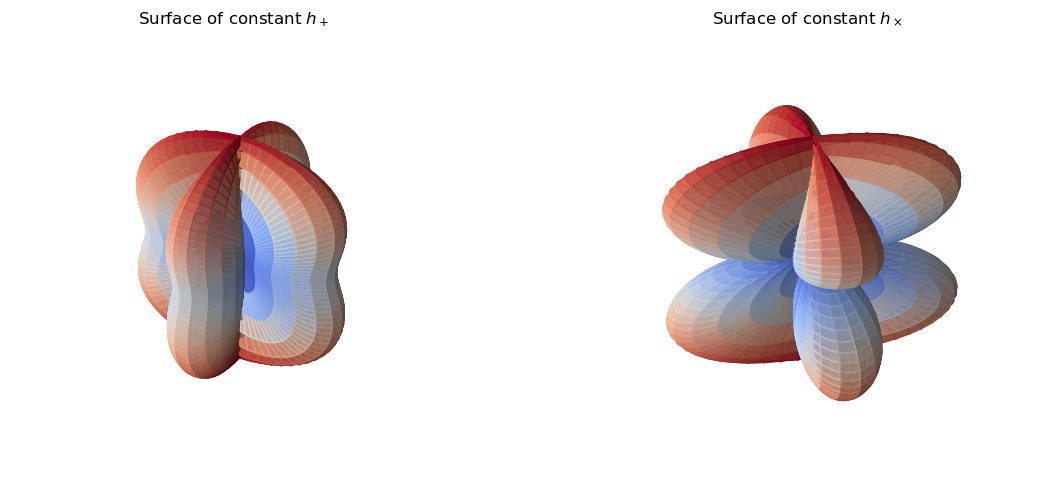

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Angles
theta = np.linspace(0, np.pi, 500)
phi = np.linspace(0, 2*np.pi, 500)
theta, phi = np.meshgrid(theta, phi)

# GW amplitude patterns for circular orbit
h0 = 1  # arbitrary units
h_plus = -h0 * (1 + np.cos(theta)**2)/2 * np.cos(2*phi)
h_cross = -2 * h0 * np.cos(theta) * np.sin(2*phi)

# Convert to spherical coordinates for plotting
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# Plot h+
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
r1 = np.abs(h_plus)
x1, y1, z1 = spherical_to_cartesian(r1, theta, phi)
ax1.plot_surface(x1, y1, z1, facecolors=plt.cm.coolwarm((r1 - r1.min()) / (r1.ptp())), alpha=0.8)
ax1.set_title('Surface of constant $h_+$')
ax1.set_box_aspect([1,1,1])

# Plot h_cross
ax2 = fig.add_subplot(122, projection='3d')
r2 = np.abs(h_cross)
x2, y2, z2 = spherical_to_cartesian(r2, theta, phi)
ax2.plot_surface(x2, y2, z2, facecolors=plt.cm.coolwarm((r2 - r2.min()) / (r2.ptp())), alpha=0.8)
ax2.set_title('Surface of constant $h_\\times$')
ax2.set_box_aspect([1,1,1])

for ax in [ax1, ax2]:
    ax.axis('off')

plt.tight_layout()
plt.show()


### 1. Time evolution of orbital phase $\psi(t)$

* $$\dot{\psi} = \sqrt{\frac{Gm}{p^3}} (1 + e \cos \psi)^2  $$

where $p$ is the semi-latus rectum, $e$ the eccentricity.

* For **circular orbits** $e=0$, this reduces to $\dot{\psi} = \sqrt{Gm/p^3} = \omega_0$, the orbital frequency, so

  $$
  \psi(t) = \omega_0 t,
  $$

and gravitational waves (GW) have frequency $f = 2\omega_0$, twice the orbital frequency.

---

### 2. Quadrupole formula for GW power and angular momentum loss

* The instantaneous GW power and angular momentum flux are expressed in terms of third derivatives of the quadrupole moment $Q_{ab}$.

* Explicit formulas given as:

  $$
  P_{GW}(\psi) = P^{e=0}_{GW} (1 + e \cos \psi)^4 \left[1 + 2 e \cos \psi + \frac{e^2}{12}(1 + 11 \cos^2 \psi) \right]
  $$

  $$
  \dot{J}_{GW}(\psi) = \dot{J}^{e=0}_{GW} (1 + e \cos \psi)^3 \left[ 1 + \frac{3}{2} e \cos \psi - \frac{e^2}{4} (1 - 3 \cos^2 \psi) \right]
  $$

* For **circular orbits**,

  $$
  P^{e=0}_{GW} = \frac{32}{5} \nu^2 \frac{c^5}{G} \left(\frac{G m}{c^2 p} \right)^5, \quad
  \dot{J}^{e=0}_{GW} = \frac{32}{5} \nu^2 (m c^2) \left(\frac{G m}{c^2 p}\right)^{7/2}.
  $$

---

### 3. Radiation reaction and secular evolution

* Over timescales much larger than the orbital period $T$, one uses orbit-averaged losses:

  $$
  \frac{dE}{dt} = - \langle P_{GW} \rangle, \quad \frac{dL}{dt} = - \langle \dot{J}_{GW} \rangle,
  $$

with averages defined by

$$
\langle X \rangle = \frac{1}{T} \int_0^T X(t) dt = \frac{1}{T} \int_{-\pi}^\pi \frac{X(\psi)}{\dot{\psi}} d\psi.
$$

* The classic **Peters & Mathews formulas** for averaged energy and angular momentum flux for elliptical orbits $e<1$ are:

  $$
  \langle P_{GW} \rangle = P^{e=0}_{GW} (1 - e^2)^{3/2} \left(1 + \frac{73}{24} e^2 + \frac{37}{96} e^4 \right),
  $$

  $$
  \langle \dot{J}_{GW} \rangle = \dot{J}^{e=0}_{GW} (1 - e^2)^{3/2} \left(1 + \frac{7}{8} e^2 \right).
  $$

* These indicate **increased radiation power for moderate eccentricities** but vanish as $e \to 1$ (parabolic limit).

---

### 4. Frequency content of GW for eccentric orbits

* The quadrupole tensor components $I_{ij}(t)$ are expanded in Fourier series over multiples $n$ of orbital frequency $\omega_0$:

  $$
  I_{ij}(t) = \nu m p^2 \left[ \tilde{A}_{ij}^{(0)} + \sum_{n=1}^\infty \left( \tilde{A}_{ij}^{(n)} \cos n \omega_0 t + \tilde{B}_{ij}^{(n)} \sin n \omega_0 t \right) \right].
  $$

* The coefficients $\tilde{A}^{(n)}_{ij}, \tilde{B}^{(n)}_{ij}$ depend on eccentricity and Bessel functions $J_n(ne)$.

* Power decomposes into harmonic contributions $\langle P_n \rangle$ at frequencies $n \omega_0$, reflecting that eccentric orbits emit GW at multiple harmonics, not just twice the orbital frequency.

---

### 5. Backreaction evolution of $p(t)$ and $e(t)$

* From angular momentum,

  $$
  L = \nu \sqrt{G m p} \implies \frac{dL}{dt} = \frac{\nu c}{2} \sqrt{\frac{G m}{c^2 p}} \frac{dp}{dt}.
  $$

* With averaged $\langle \dot{J}_{GW} \rangle$, the decay of $p$ is:

  $$
  \frac{dp}{dt} = - \frac{64}{5} \nu c \left(\frac{G m}{c^2 p}\right)^3 (1 - e^2)^{3/2} \left(1 + \frac{7}{8} e^2\right).
  $$

* Similarly, from the energy,

  $$
  \frac{de}{dt} = - \frac{304}{15} \nu c \frac{e}{p} \left(\frac{G m}{c^2 p}\right)^3 (1 - e^2)^{3/2} \left(1 + \frac{121}{304} e^2\right).
  $$

* **Result:** $p$ and $e$ both decrease over time due to GW emission, making orbits more circular.

* The radiation reaction timescale $\tau_R$ is much longer than the orbital period $T$.

---

### 6. Frequency evolution and waveform

* The orbital period $T$ decreases (frequency increases) as

  $$
  \frac{dT}{dt} = - \frac{192}{5} \pi \left( \frac{G \mathcal{M}}{c^3} \frac{2\pi}{T} \right)^{5/3} \frac{1 + \frac{73}{24} e^2 + \frac{37}{96} e^4}{(1 - e^2)^{7/2}},
  $$

  where $\mathcal{M}$ is the chirp mass.

* Waveforms $h_{+,\times}(t)$ are computed substituting $e(t), p(t)$ into the phase evolution $\psi(t)$.

---

### 7. Circular orbit special case: analytic solution

* For $e=0$, orbital angular frequency:

  $$
  \omega(t) = 2 \pi f(t) = 2 \sqrt{\frac{G m}{p^3(t)}},
  $$

with

$$
\dot{\omega} = \frac{12}{5} \sqrt{2} \left( \frac{G \mathcal{M}}{c^3} \right)^{5/3} \omega^{11/3}.
$$

* In terms of GW frequency,

  $$
  \dot{f} = \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}}{c^3} \right)^{5/3} f^{11/3},
  $$

and integrated frequency evolution near coalescence $t_c$ is:

$$
f(\tau) = \frac{1}{\pi} \left(\frac{5}{256}\right)^{3/8} \left(\frac{G \mathcal{M}}{c^3}\right)^{-5/8} \tau^{-3/8}, \quad \tau = t_c - t.
$$

* The phase $\Phi = 2 \psi$ evolves as

  $$
  \Phi(\tau) = -2 \left(\frac{5 G \mathcal{M}}{c^3}\right)^{-5/8} \tau^{5/8} + \Phi_c,
  $$

leading to the characteristic "chirp" waveform.




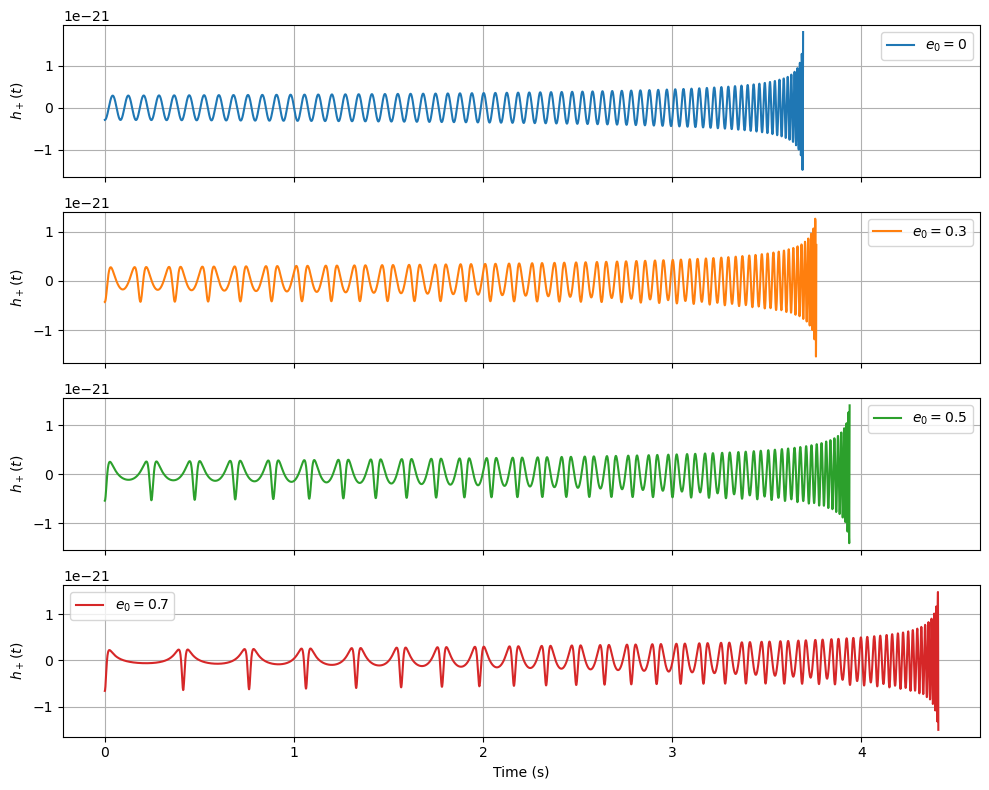

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11
c = 299792458
m1 = 30 * 1.9885e30
m2 = 30 * 1.9885e30
m = m1 + m2
nu = (m1 * m2) / m**2
R = 500e6 * 3.086e16
p0 = 20 * G * m / c**2
p_isco = 3 * G * m / c**2

def dpdt(t, p, e):
    return -(64/5) * nu * c * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (7/8) * e**2)

def dedt(t, p, e):
    dot_e = -(304/15) * nu * c * e / p * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (121/304) * e**2)
    return 3*dot_e

def dpsidt(t, psi, p, e):
    return np.sqrt(G * m / p**3) * (1 + e * np.cos(psi))**2

def h_plus(t, psi, e, h0):
    return -h0 * (2 * np.cos(2 * psi) + e * np.cos(psi) + 2 * e * np.cos(psi)**3 + e**2)

def solve_system(e0, t_max, dt):
    def odes(t, y):
        p, e, psi = y
        return [dpdt(t, p, e), dedt(t, p, e), dpsidt(t, psi, p, e)]

    def isco_reached(t, y):
        return y[0] - p_isco
    isco_reached.terminal = True
    isco_reached.direction = -1

    y0 = [p0, e0, 0]
    t_span = (0, t_max)
    t_eval = np.arange(0, t_max, dt)
    sol = solve_ivp(odes, t_span, y0, t_eval=t_eval, events=isco_reached, rtol=1e-9, atol=1e-9)

    p_sol, e_sol, psi_sol = sol.y
    h0 = 2 * G**2 * m1 * m2 / (c**4 * R * p_sol)
    hplus = h_plus(sol.t, psi_sol, e_sol, h0)

    return sol.t, hplus

# Plotting
e0_list = [0, 0.3, 0.5, 0.7]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, axs = plt.subplots(len(e0_list), 1, figsize=(10, 8), sharex=True)

for ax, e0, color in zip(axs, e0_list, colors):
    t, hplus = solve_system(e0, t_max=400, dt=0.001)
    ax.plot(t, hplus, color=color, label=f'$e_0 = {e0}$')
    ax.set_ylabel(r'$h_+(t)$')
    ax.legend()
    ax.grid(True)

axs[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()


After plotting the waveform, we can plot the orbit of the associated compact object.


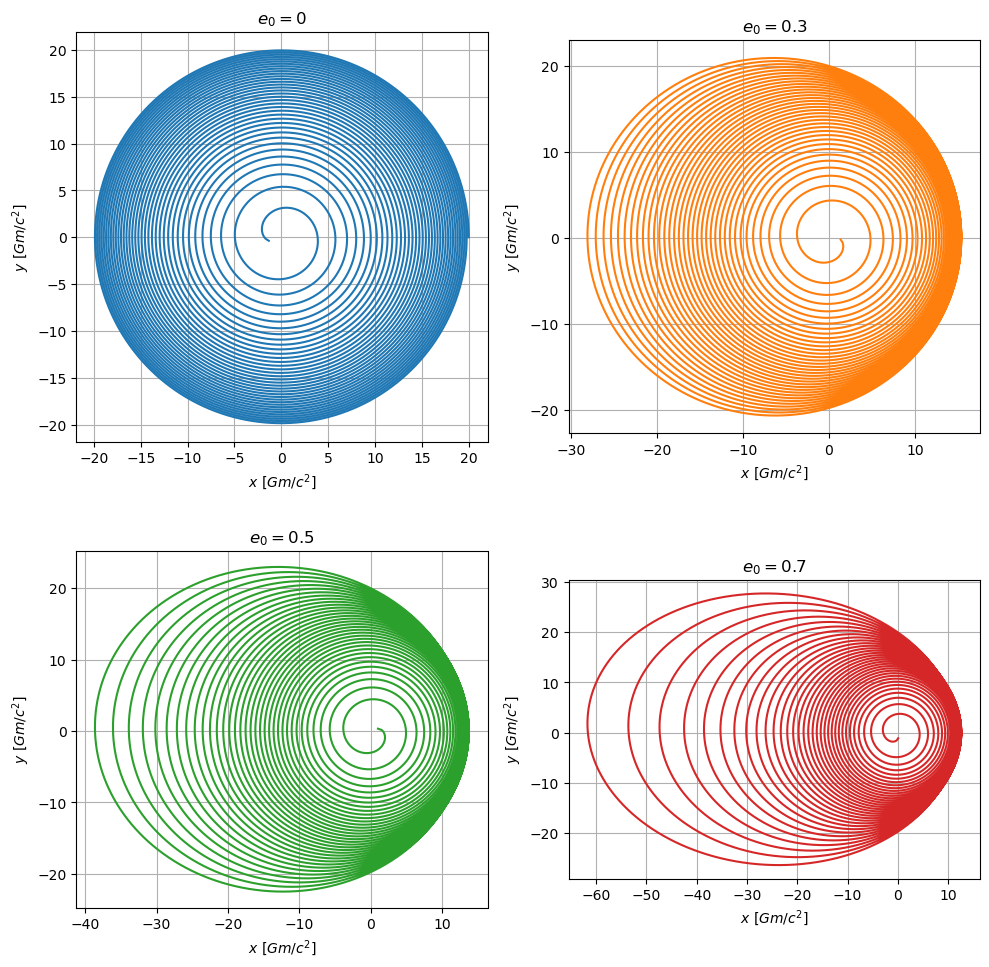

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11
c = 299792458
m1 = 30 * 1.9885e30
m2 = 30 * 1.9885e30
m = m1 + m2
nu = (m1 * m2) / m**2
p0 = 20 * G * m / c**2
p_isco = 0 * 2 * G * m / c**2

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

def dpdt(t, p, e):
    return -(64/5) * nu * c * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (7/8) * e**2)

def dedt(t, p, e):
    return -3*(304/15) * nu * c * e / p * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (121/304) * e**2)

def dpsidt(t, psi, p, e):
    return np.sqrt(G * m / p**3) * (1 + e * np.cos(psi))**2

def solve_orbit(e0, t_max, dt):
    def odes(t, y):
        p, e, psi = y
        return [dpdt(t, p, e), dedt(t, p, e), dpsidt(t, psi, p, e)]

    def isco_event(t, y):
        return y[0] - p_isco
    isco_event.terminal = True
    isco_event.direction = -1

    y0 = [p0, e0, 0]
    t_eval = np.arange(0, t_max, dt)
    sol = solve_ivp(odes, (0, t_max), y0, t_eval=t_eval, events=isco_event, rtol=1e-9, atol=1e-9)

    p_sol, e_sol, psi_sol = sol.y
    r_sol = p_sol / (1 + e_sol * np.cos(psi_sol))
    x_sol = r_sol * np.cos(psi_sol)
    y_sol = r_sol * np.sin(psi_sol)
    return x_sol, y_sol

# Plotting
e0_list = [0, 0.3, 0.5, 0.7]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, e0, color in zip(axs.flatten(), e0_list, colors):
    x, y = solve_orbit(e0, t_max=200, dt=0.0001)
    ax.plot(x / (G * m / c**2), y / (G * m / c**2), color=color)
    ax.set_title(f'$e_0 = {e0}$')
    ax.set_xlabel(r'$x~[Gm/c^2]$')
    ax.set_ylabel(r'$y~[Gm/c^2]$')
    ax.set_aspect('equal')
    ax.grid(True)

plt.tight_layout()
plt.show()


And then we can combine the two plots to see the waveform and the orbit together, showing the impact of the decrease in $e(t)$ and $p(t)$, which makes the orbit more circular and reduces its radius.


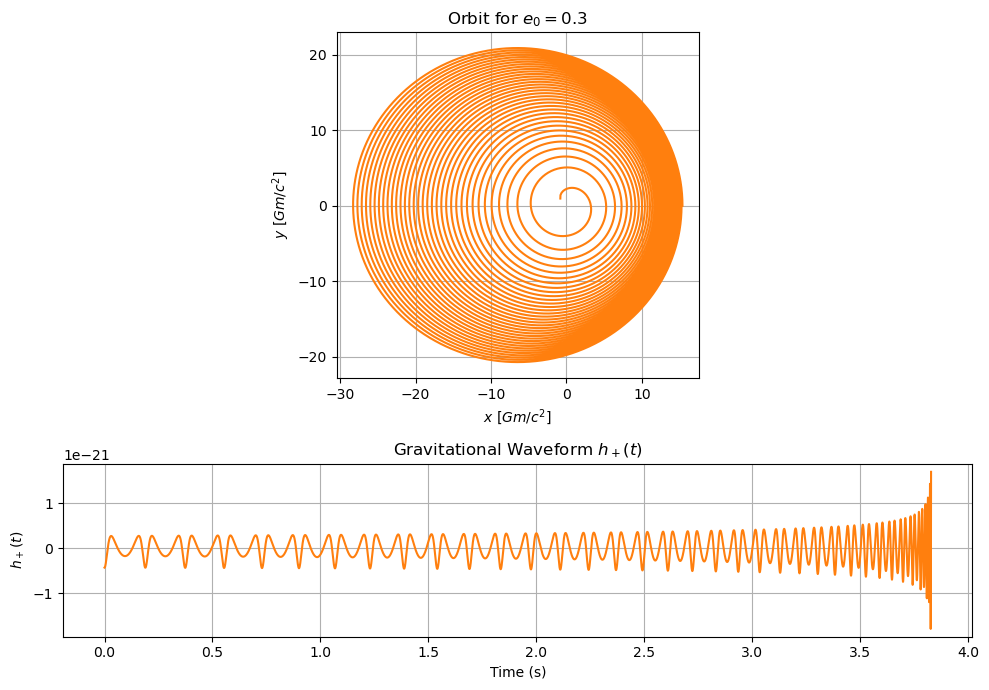

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11
c = 299792458
m1 = 30 * 1.9885e30
m2 = 30 * 1.9885e30
m = m1 + m2
nu = (m1 * m2) / m**2
R = 500e6 * 3.086e16  # Distance in meters
p0 = 20 * G * m / c**2
p_isco_wave = 2.5 * G * m / c**2
p_isco_orbit = 0*p_isco_wave

color = 'tab:orange'

def dpdt(t, p, e):
    return -(64/5) * nu * c * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (7/8) * e**2)

def dedt(t, p, e):
    dot_e = -(304/15) * nu * c * e / p * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (121/304) * e**2)
    return 1 * dot_e

def dpsidt(t, psi, p, e):
    return np.sqrt(G * m / p**3) * (1 + e * np.cos(psi))**2

def h_plus(t, psi, e, h0):
    return -h0 * (2 * np.cos(2 * psi) + e * np.cos(psi) + 2 * e * np.cos(psi)**3 + e**2)

def solve_with_isco(e0, t_max, dt, p_isco_stop):
    def odes(t, y):
        p, e, psi = y
        return [dpdt(t, p, e), dedt(t, p, e), dpsidt(t, psi, p, e)]

    def isco_event(t, y):
        return y[0] - p_isco_stop
    isco_event.terminal = True
    isco_event.direction = -1

    y0 = [p0, e0, 0]
    t_eval = np.arange(0, t_max, dt)
    sol = solve_ivp(odes, (0, t_max), y0, t_eval=t_eval, events=isco_event, rtol=1e-9, atol=1e-9)
    return sol

# Parameters
e0 = 0.3
t_max = 400
dt = 0.0001

# Solve for orbit (stop at p_isco_orbit)
sol_orbit = solve_with_isco(e0, t_max, dt, p_isco_orbit)
p_orb, e_orb, psi_orb = sol_orbit.y
t_orb = sol_orbit.t
r_orb = p_orb / (1 + e_orb * np.cos(psi_orb))
x_orb = r_orb * np.cos(psi_orb)
y_orb = r_orb * np.sin(psi_orb)

# Solve for waveform (stop at p_isco_wave)
sol_wave = solve_with_isco(e0, t_max, dt, p_isco_wave)
p_wave, e_wave, psi_wave = sol_wave.y
t_wave = sol_wave.t
h0_wave = 2 * G**2 * m1 * m2 / (c**4 * R * p_wave)
hplus = h_plus(t_wave, psi_wave, e_wave, h0_wave)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})

# Orbit plot
axs[0].plot(x_orb / (G * m / c**2), y_orb / (G * m / c**2), color=color)
axs[0].set_title(f'Orbit for $e_0 = {e0}$')
axs[0].set_xlabel(r'$x~[Gm/c^2]$')
axs[0].set_ylabel(r'$y~[Gm/c^2]$')
axs[0].set_aspect('equal')
axs[0].grid(True)

# Waveform plot
axs[1].plot(t_wave, hplus, color=color)
axs[1].set_title(r'Gravitational Waveform $h_+(t)$')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel(r'$h_+(t)$')
axs[1].grid(True)

plt.tight_layout()
plt.show()
